# Fehlerdetektion und Diagnose: Baselines für Fehlerdetektion in Zeitreihen am Beispiel des FCCU Datensatzes

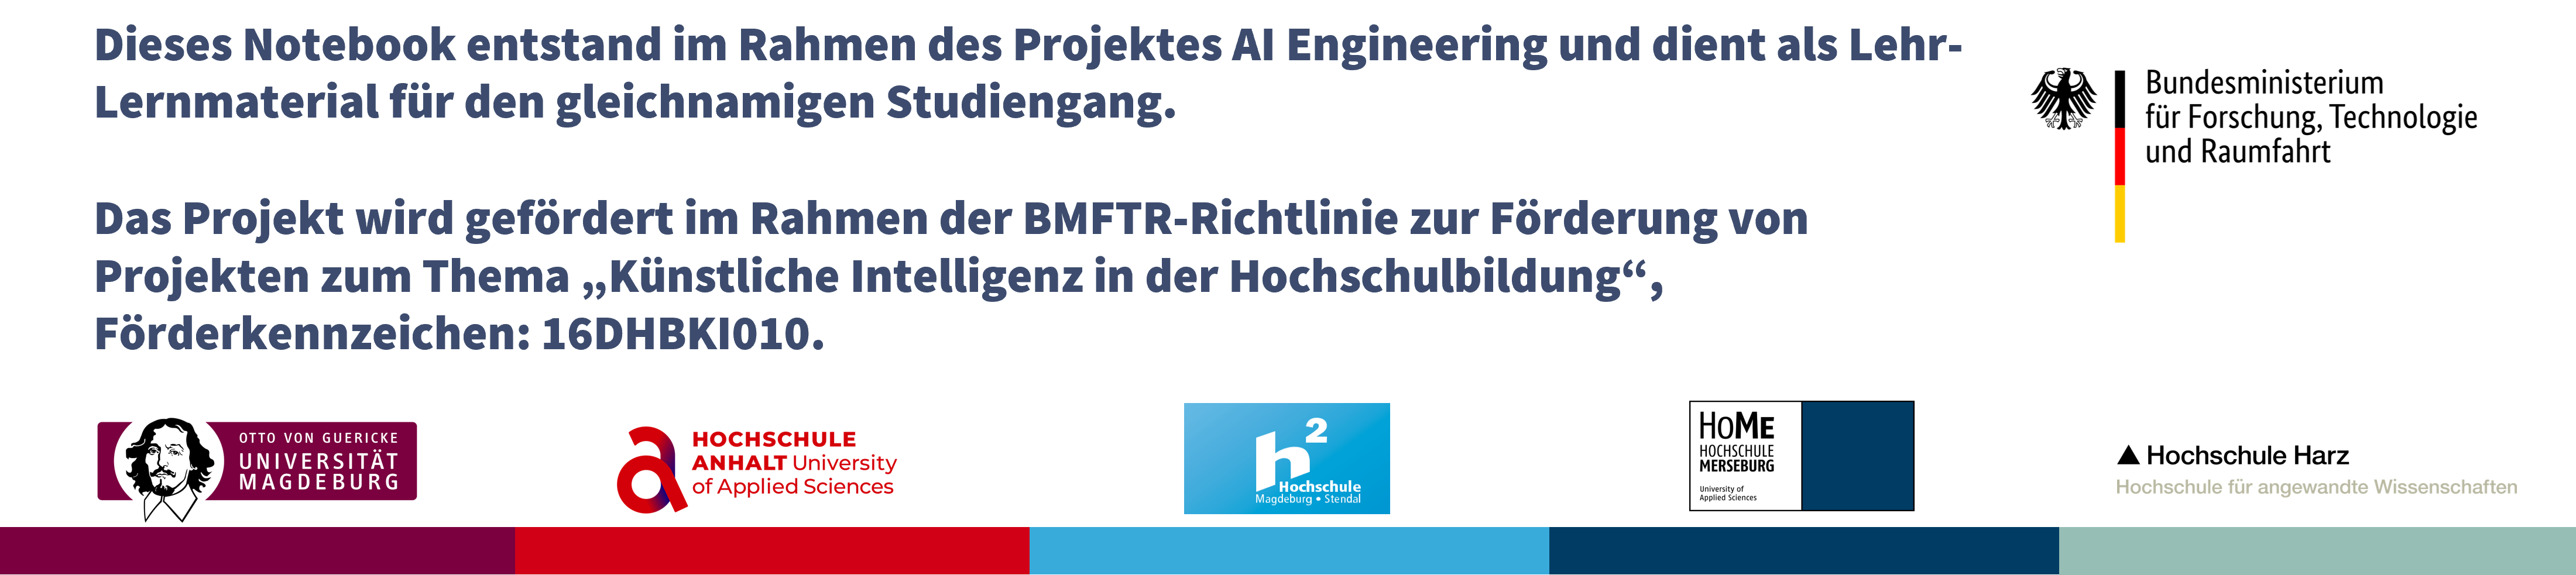

Kontakt: https://ai-engineer.de 

**Lizenzhinweise:**  
Diese Datei ist Teil der Reihe zur Fehlerdetektion und Diagnose in der Prozessautomation, eine Lehrveranstaltung an der Hochschule Merseburg, Merseburg, Deutschland.

Sie sollte zusammen mit den Vorlesungsfolien und weiteren Materialien genutzt werden. Eine Kopie der Materialien ist zusammen mit dem Lizenztext zu nutzen und weiterzugeben, ebenso sollen Übungs- und Praktikumsblättern sowie eine geeignete Testumgebung für die Praktika zur Verfügung stehen.

### WIP! Zitation und Urheber.
**Autor:** 

**Dataset:** FCCU-Dataset (MIT-Lizenz) von Ankur Kumar/ML-PSE. Bitte die CSVs lokal bereitstellen.

**Juypter Notebook:** basierend auf den Jupyter Notebooks von Ankur Kumar unter MIT Lizenz.

**MIT License**  
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

---

## Ziel
Dieses Notebook stellt **reproduzierbare Baselines (Vergleichstest für spätere Optimierungen)** bereit, um **fehlerfreie (NOC)** von **fehlerhaften Zuständen** der FCCU-Zeitreihen zu unterscheiden.  
Es nutzt klassische und leichtgewichtige Modelle, die in Standard-Python-Stacks verfügbar sind.

**Modelle/Methoden:**
1. **Dynamic PCA (DPCA)** über Zeitverzögerungs-Einbettung (T^2, Q)  
2. **Kernel PCA (RBF)** über Rekonstruktionsfehler  
3. **Isolation Forest** (Unsupervised)  
4. **One-Class SVM** (Novelty Detection)  
5. **Local Outlier Factor** (novelty=True)  
6. **Shallow Autoencoder** (sklearn `MLPRegressor`)  
7. **(Optional)** Random Forest (supervised)  
8. **CUSUM**-basierte Change-Detection (univariates Signal, aggregiert)

**Hinweis zu Daten:** In diesem Notebook wird **keine** Datenbeschaffung durchgeführt. Bitte legen Sie die FCCU-CSV-Dateien lokal ab und passen Sie die Pfade im **CONFIG**-Abschnitt an.

## CONFIG – Pfade, Spalten, Parameter

Passen Sie den Block unter diesem an **Ihre lokalen Dateipfade** an. Die Benennung orientiert sich am ML-PSE/FCCU-Repo, welches als Grundlage für diese Arbeiten diente:
- `NOC_stableFeedFlow_outputs.csv`
- `NOC_varyingFeedFlow_outputs.csv`
- `condEff_decrease_outputs.csv`
- `deltaP_increase_outputs.csv`
- `UAf_decrease_outputs.csv`
- `Fhn_sensorDrift_outputs.csv`
- `CAB_valveLeak_outputs.csv`

Sie können mit **einer beliebigen Anazhl an NOC und Fault-Dateien (n>1)** beginnen und später erweitern.


In [4]:

# --- Pfade anpassen ---
DATA_DIR = "./"  # Ordner mit den CSVs (anpassen bei Änderungen an Ihrer Datenstruktur!)

FILES = {
    "NOC_stable": f"{DATA_DIR}/NOC_stableFeedFlow_outputs.csv",
    "NOC_varying": f"{DATA_DIR}/NOC_varyingFeedFlow_outputs.csv",
    # Beispiel: nur einige Faults aktivieren; weitere bei Bedarf ergänzen
#    "FAULT_condEff": f"{DATA_DIR}/condEff_decrease_outputs.csv",
#    "FAULT_deltaP": f"{DATA_DIR}/deltaP_increase_outputs.csv",
    "FAULT_UAf": f"{DATA_DIR}/UAf_decrease_outputs.csv",
#    "FAULT_sensorDrift": f"{DATA_DIR}/Fhn_sensorDrift_outputs.csv",
#    "FAULT_valveLeak": f"{DATA_DIR}/CAB_valveLeak_outputs.csv",
}

# --- Allgemeine Parameter ---
TIME_COL_CANDIDATES = ["time", "timestamp", "t"]   # Auto-Erkennung der Zeitspalten-Benennung
DROP_COLS = []  # z.B. nicht-numerische oder ID-Spalten hier eintragen, die ignoriert werden sollen

# Sliding-Window (Samples aus Sequenzen)
WINDOW = 60      # Anzahl Zeitpunkte pro Fenster
HOP = 10         # Schrittweite zwischen Fenstern
MAX_ROWS_PER_FILE = None  # z.B. 50000 zum Debuggen; None = alle

# Modell-Parameter für die Auswertung
RANDOM_STATE = 42 
TEST_SIZE = 0.5  # Testanteil bezogen auf Fault-Daten beim Mix zur Testung / Evaluierung

# False Alarm rate auf den NOC Bereich bezogen
target_far=0.001


In [6]:
# ============================================================
# Guard für überwachte Modelle (z. B. RandomForest)
#   - Nur ausführen, wenn alle gewünschten Fault-Dateien geladen sind
#   - Modus: REQUIRE_LIST (empfohlen) oder REQUIRE_COUNT (alternativ)
# ============================================================
import os

# === Konfiguration ===
GUARD_MODE = "REQUIRE_COUNT"   # "REQUIRE_LIST" oder "REQUIRE_COUNT"

# Variante A: Exakte Liste der Fault-Keys, so wie sie in FILES/data heißen:
FAULT_KEYS_REQUIRED = ["FAULT_01", "FAULT_02", "FAULT_03", "FAULT_sensorDrift", "FAULT_05"]  # <- an deine Keys anpassen

# Variante B: Mindestanzahl an Fault-Dateien (wenn du keine feste Liste pflegen willst)
FAULT_COUNT_REQUIRED = 5  # wird nur für GUARD_MODE == "REQUIRE_COUNT" verwendet

# Überwachte Modelle, die vom Guard betroffen sind (nur für Logs)
SUPERVISED_BLOCKS = ["RandomForestClassifier"]  # ggf. erweitern (z. B. "XGBoost", "SVM (supervised)" etc.)

def _normalize_fault_keys_from(FILES=None, data=None):
    """Sammelt alle Fault-Keys aus FILES oder data (case-insensitive auf 'FAULT')."""
    loaded = set()
    if FILES and isinstance(FILES, dict):
        for k, v in FILES.items():
            if "FAULT" in str(k).upper():
                loaded.add(str(k))
    if data and isinstance(data, dict):
        for k in data.keys():
            if "FAULT" in str(k).upper():
                loaded.add(str(k))
    return loaded

def guard_supervised(FILES=None, data=None, mode="REQUIRE_LIST",
                     required_keys=None, required_count=None):
    loaded_faults = _normalize_fault_keys_from(FILES, data)
    missing = []
    ok = False

    if mode == "REQUIRE_LIST":
        required_keys = list(required_keys or [])
        missing = [k for k in required_keys if k not in loaded_faults]
        ok = (len(missing) == 0)
        info = f"erwartet={required_keys} | geladen={sorted(loaded_faults)}"
    elif mode == "REQUIRE_COUNT":
        need = int(required_count or 0)
        ok = (len(loaded_faults) >= need)
        info = f"min_anzahl={need} | geladen={len(loaded_faults)} -> {sorted(loaded_faults)}"
    else:
        # Fallback: mind. eine Fault-Datei muss da sein
        ok = (len(loaded_faults) > 0)
        info = f"geladen={sorted(loaded_faults)}"

    return ok, loaded_faults, missing, info

# ---- Guard anwenden (FILES oder data müssen schon existieren) ----
FILES_obj = FILES if 'FILES' in globals() else None
data_obj  = data  if 'data'  in globals() else None

USE_SUPERVISED = True
ok, loaded_faults, missing_faults, info = guard_supervised(
    FILES=FILES_obj, data=data_obj,
    mode=GUARD_MODE,
    required_keys=FAULT_KEYS_REQUIRED,
    required_count=FAULT_COUNT_REQUIRED
)

if not ok:
    USE_SUPERVISED = False
    print("⚠ Überwachtes Training DEAKTIVIERT.")
    print(f"   Grund: Fault-Guard nicht erfüllt [{GUARD_MODE}].")
    if missing_faults:
        print(f"   Fehlende Fault-Keys: {missing_faults}")
    print(f"   Details: {info}")
    print(f"   Betroffene Blöcke: {', '.join(SUPERVISED_BLOCKS)}")
else:
    print("✓ Überwachtes Training AKTIVIERT (Guard erfüllt).")
    print(f"   Details: {info}")


⚠ Überwachtes Training DEAKTIVIERT.
   Grund: Fault-Guard nicht erfüllt [REQUIRE_COUNT].
   Details: min_anzahl=5 | geladen=1 -> ['FAULT_UAf']
   Betroffene Blöcke: RandomForestClassifier


In [7]:

import os, math, numpy as np, pandas as pd
from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

np.random.seed(RANDOM_STATE)

def _read_csv_safe(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Datei nicht gefunden: {path}")
    df = pd.read_csv(path)
    # Zeitspalte erkennen (falls vorhanden)
    for c in TIME_COL_CANDIDATES:
        if c in df.columns:
            try:
                df[c] = pd.to_datetime(df[c])
                df = df.sort_values(c)
                df = df.reset_index(drop=True)
                break
            except Exception:
                pass
    return df

def _numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    if DROP_COLS:
        df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors="ignore")
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
    return num

def load_fccu_files(files: Dict[str,str], max_rows: int=None) -> Dict[str, pd.DataFrame]:
    data = {}
    for k, p in files.items():
        try:
            df = _read_csv_safe(p)
            if max_rows:
                df = df.iloc[:max_rows].copy()
            data[k] = _numeric_df(df)
            print(f"✔ Geladen: {k} -> {df.shape} (numerisch: {data[k].shape})")
        except FileNotFoundError as e:
            print(f"⚠ Übersprungen (nicht gefunden): {k} -> {p}")
    return data

def make_windows(X: np.ndarray, window: int, hop: int) -> np.ndarray:
    # [T, D] -> [N, window*D], mit stride hop
    T, D = X.shape
    if T < window:
        return np.empty((0, window * D))
    idx = list(range(0, T - window + 1, hop))
    out = np.empty((len(idx), window * D), dtype=float)
    for i, s in enumerate(idx):
        seg = X[s:s+window, :]
        out[i] = seg.reshape(-1)
    return out

def standardize(train_X: np.ndarray, test_X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, StandardScaler]:
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(train_X)
    Xte = scaler.transform(test_X)
    return Xtr, Xte, scaler

def dpca_scores(Xtr: np.ndarray, Xte: np.ndarray, n_components: int=None) -> Tuple[np.ndarray, np.ndarray, PCA]:
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    Ztr = pca.fit_transform(Xtr)
    Zte = pca.transform(Xte)
    # T^2
    T2_tr = np.sum((Ztr / (pca.singular_values_[:Ztr.shape[1]] + 1e-12))**2, axis=1)
    T2_te = np.sum((Zte / (pca.singular_values_[:Zte.shape[1]] + 1e-12))**2, axis=1)
    # SPE/Q
    Xtr_hat = pca.inverse_transform(Ztr)
    Xte_hat = pca.inverse_transform(Zte)
    SPE_tr = np.sum((Xtr - Xtr_hat)**2, axis=1)
    SPE_te = np.sum((Xte - Xte_hat)**2, axis=1)
    # Aggregierter Score
    score_tr = (T2_tr / (np.median(T2_tr)+1e-9)) + (SPE_tr / (np.median(SPE_tr)+1e-9))
    score_te = (T2_te / (np.median(T2_te)+1e-9)) + (SPE_te / (np.median(SPE_te)+1e-9))
    return score_tr, score_te, pca

def kpca_recon_error(Xtr: np.ndarray, Xte: np.ndarray, n_components: int=10, gamma: float=None) -> Tuple[np.ndarray, np.ndarray, KernelPCA]:
    kpca = KernelPCA(n_components=n_components, kernel="rbf", gamma=gamma, fit_inverse_transform=True, random_state=RANDOM_STATE)
    Ztr = kpca.fit_transform(Xtr)
    Zte = kpca.transform(Xte)
    Xtr_hat = kpca.inverse_transform(Ztr)
    Xte_hat = kpca.inverse_transform(Zte)
    err_tr = np.sum((Xtr - Xtr_hat)**2, axis=1)
    err_te = np.sum((Xte - Xte_hat)**2, axis=1)
    return err_tr, err_te, kpca

def oneclass_methods(Xtr: np.ndarray, Xte: np.ndarray) -> Dict[str, np.ndarray]:
    out = {}
    # Isolation Forest
    iforest = IsolationForest(n_estimators=200, contamination='auto', random_state=RANDOM_STATE)
    iforest.fit(Xtr)
    out["isoforest"] = -iforest.score_samples(Xte)
    # One-Class SVM (RBF)
    oc = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)
    oc.fit(Xtr)
    # decision_function: positive ~ inlier; wir nehmen negatives als Anomalie-Score
    out["ocsvm"] = -oc.decision_function(Xte).ravel()
    # LOF in Novelty-Mode
    lof = LocalOutlierFactor(n_neighbors=35, novelty=True)
    lof.fit(Xtr)
    out["lof"] = -lof.decision_function(Xte).ravel()
    return out

def shallow_autoencoder(Xtr: np.ndarray, Xte: np.ndarray, hidden_ratio: float=0.5, max_iter: int=200) -> Tuple[np.ndarray, np.ndarray, MLPRegressor]:
    d = Xtr.shape[1]
    h = max(4, int(d*hidden_ratio))
    ae = MLPRegressor(hidden_layer_sizes=(h,), activation="relu", solver="adam",
                      max_iter=max_iter, random_state=RANDOM_STATE, verbose=False)
    # Autoencoder per Feature-Rekonstruktion (multi-output Regression)
    ae.fit(Xtr, Xtr)
    tr_hat = ae.predict(Xtr)
    te_hat = ae.predict(Xte)
    err_tr = np.sum((Xtr - tr_hat)**2, axis=1)
    err_te = np.sum((Xte - te_hat)**2, axis=1)
    return err_tr, err_te, ae

def simple_cusum(x: np.ndarray, k: float=0.5, h: float=5.0) -> np.ndarray:
    # Einfache CUSUM auf z-transformiertem Signal; gibt Score pro Zeitfenster zurück
    z = (x - np.mean(x)) / (np.std(x)+1e-9)
    s_pos = 0.0
    s_neg = 0.0
    scores = np.zeros_like(z, dtype=float)
    for i, xi in enumerate(z):
        s_pos = max(0.0, s_pos + (xi - k))
        s_neg = max(0.0, s_neg + (-xi - k))
        scores[i] = max(s_pos, s_neg)
    return scores

def eval_scores(y_true: np.ndarray, score: np.ndarray, title: str="") -> dict:
    # Binäre Labels: 0=NOC, 1=Fault
    auc = roc_auc_score(y_true, score)
    ap = average_precision_score(y_true, score)
    print(f"{title} -> ROC-AUC={auc:.3f}, AP={ap:.3f}")
    return {"roc_auc": auc, "ap": ap}

print("Umgebung bereit.")


Umgebung bereit.


## Daten laden & Fenster bilden

Wir erstellen einen Mix aus **NOC** und **FAULT**-Fenstern für das Training der Unsupervised-Modelle und für Test/Evaluation.

In [9]:

data = load_fccu_files(FILES, max_rows=MAX_ROWS_PER_FILE)

# NOC-Pool
noc_keys = [k for k in data if k.startswith("NOC")]
fault_keys = [k for k in data if k.startswith("FAULT")]

assert len(noc_keys) >= 1, "Mindestens eine NOC-Datei wird benötigt."
assert len(fault_keys) >= 1, "Mindestens eine FAULT-Datei wird benötigt."

# NOC zusammenführen
noc_df = pd.concat([data[k] for k in noc_keys], axis=0, ignore_index=True)
fault_df = pd.concat([data[k] for k in fault_keys], axis=0, ignore_index=True)

print("NOC gesamt:", noc_df.shape, "| FAULT gesamt:", fault_df.shape)

# Windows bauen
X_noc_win = make_windows(noc_df.values, WINDOW, HOP)
X_fault_win = make_windows(fault_df.values, WINDOW, HOP)

print("Windows:", X_noc_win.shape, X_fault_win.shape)

# Train (nur NOC) / Test (Mix aus NOC+FAULT)
X_noc_train, X_noc_test = train_test_split(X_noc_win, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
X_test = np.vstack([X_noc_test, X_fault_win])
y_test = np.hstack([np.zeros(len(X_noc_test), dtype=int), np.ones(len(X_fault_win), dtype=int)])

# Standardisierung
Xtr, Xte, scaler = standardize(X_noc_train, X_test)
print("Train/Test:", Xtr.shape, Xte.shape, "| Fault-Anteil im Test:", y_test.mean())


✔ Geladen: NOC_stable -> (2879, 47) (numerisch: (2879, 47))
✔ Geladen: NOC_varying -> (10079, 47) (numerisch: (10079, 47))
✔ Geladen: FAULT_UAf -> (1439, 47) (numerisch: (1439, 47))
NOC gesamt: (12958, 47) | FAULT gesamt: (1439, 47)
Windows: (1290, 2820) (138, 2820)
Train/Test: (645, 2820) (783, 2820) | Fault-Anteil im Test: 0.17624521072796934


## (1) Dynamic PCA (DPCA) via Zeitverzögerungs-Einbettung

Wir approximieren **DPCA** (Ku et al., 1995) durch **Fensterung** (lag embedding) und PCA. Scores über aggregiertes \(T^2\)+SPE.


DPCA (lagged PCA) -> ROC-AUC=0.973, AP=0.965


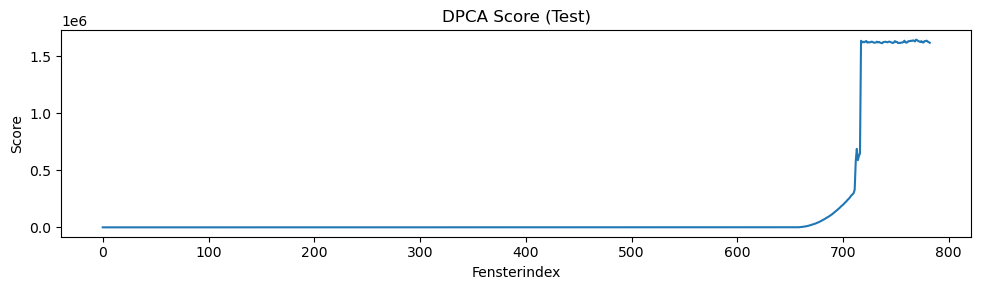

In [11]:

dpca_tr, dpca_te, pca_model = dpca_scores(Xtr, Xte, n_components=None)
res_dpca = eval_scores(y_test, dpca_te, "DPCA (lagged PCA)")

# Timeline-Plot (nur Score-Verlauf des Testsets)
plt.figure(figsize=(10,3))
plt.plot(dpca_te)
plt.title("DPCA Score (Test)")
plt.xlabel("Fensterindex")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## (2) Kernel PCA (RBF) Rekonstruktionsfehler

Kernel PCA (RBF) -> ROC-AUC=0.676, AP=0.334


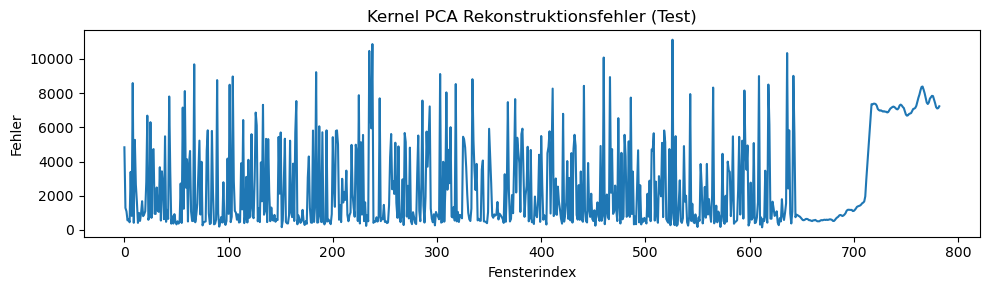

In [13]:

kpca_tr, kpca_te, kpca_model = kpca_recon_error(Xtr, Xte, n_components=10, gamma=None)
res_kpca = eval_scores(y_test, kpca_te, "Kernel PCA (RBF)")
plt.figure(figsize=(10,3))
plt.plot(kpca_te)
plt.title("Kernel PCA Rekonstruktionsfehler (Test)")
plt.xlabel("Fensterindex")
plt.ylabel("Fehler")
plt.tight_layout()
plt.show()


## (3–5) Unsupervised Novelty Detection: Isolation Forest, One-Class SVM, LOF

ISOFOREST -> ROC-AUC=0.339, AP=0.128
OCSVM -> ROC-AUC=0.933, AP=0.832
LOF -> ROC-AUC=0.894, AP=0.827


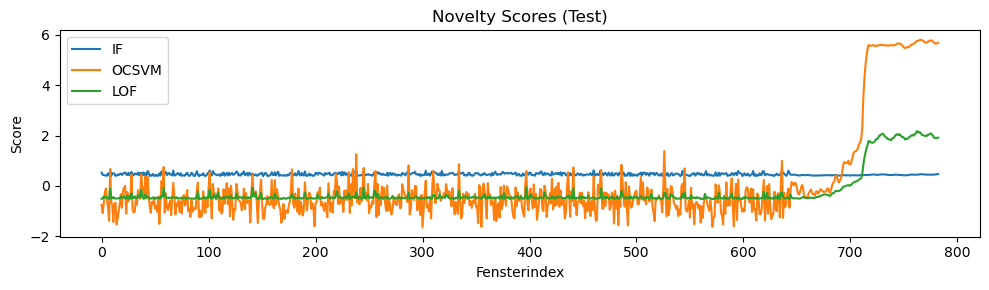

In [15]:

scores = oneclass_methods(Xtr, Xte)
res_oneclass = {}
for name, sc in scores.items():
    res_oneclass[name] = eval_scores(y_test, sc, name.upper())

plt.figure(figsize=(10,3))
plt.plot(scores["isoforest"], label="IF")
plt.plot(scores["ocsvm"], label="OCSVM")
plt.plot(scores["lof"], label="LOF")
plt.legend()
plt.title("Novelty Scores (Test)")
plt.xlabel("Fensterindex")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## (6) Shallow Autoencoder (sklearn `MLPRegressor`)

Shallow Autoencoder (MLP) -> ROC-AUC=0.927, AP=0.899


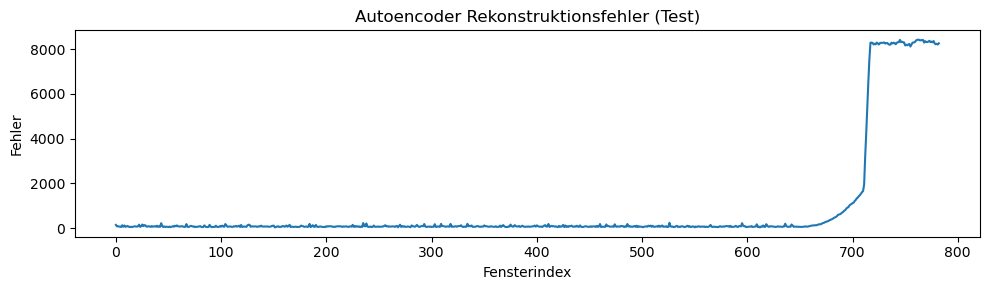

In [17]:

ae_tr, ae_te, ae_model = shallow_autoencoder(Xtr, Xte, hidden_ratio=0.5, max_iter=200)
res_ae = eval_scores(y_test, ae_te, "Shallow Autoencoder (MLP)")

plt.figure(figsize=(10,3))
plt.plot(ae_te)
plt.title("Autoencoder Rekonstruktionsfehler (Test)")
plt.xlabel("Fensterindex")
plt.ylabel("Fehler")
plt.tight_layout()
plt.show()


## (7) Überwachtes Lernen / Supervised: Random Forest auf NOC vs. Fault

Wenn Labels verfügbar sind (hier per Dateigruppe), kann ein klassischer **Random Forest** auf den Fenster-Features trainiert werden.
## Achtung, Random Forest kann nur trainiert werden, wenn alle Faults verfügbar sind!
-> sosnt können Entscheidungsbäume nicht richtig trainiert werden!
Guard-Funktion prüft dies hier und nach dem Laden der Daten.

In [19]:
## WIP
# Beispiel: Random Forest Training nur, wenn Guard erfüllt ist
if USE_SUPERVISED:
    print("→ Starte RandomForest-Training …")
    # Supervised Train/Val nur zum Vergleich: Wir sampeln balanced aus NOC-Train und Fault
    n_fault = min(len(X_fault_win), len(X_noc_train))
    X_rf = np.vstack([X_noc_train[:n_fault], X_fault_win[:n_fault]])
    y_rf = np.hstack([np.zeros(n_fault, dtype=int), np.ones(n_fault, dtype=int)])

    Xtr_rf, Xte_rf, _ = standardize(X_rf, X_test)  # fit auf Trainingsmix
    rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(Xtr_rf, y_rf)
    proba = rf.predict_proba(Xte_rf)[:,1]

    res_rf = eval_scores(y_test, proba, "RandomForest (supervised)")

    plt.figure(figsize=(10,3))
    plt.plot(proba)
    plt.title("RandomForest Fault-Wahrscheinlichkeit (Test)")
    plt.xlabel("Fensterindex")
    plt.ylabel("p(fault)")
    plt.tight_layout()
    plt.show()
    clf = RandomForestClassifier(...)
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:,1]
    res_rf = eval_scores(proba, y_test)
else:
    print("⏭ RandomForest übersprungen (USE_SUPERVISED = False).")




⏭ RandomForest übersprungen (USE_SUPERVISED = False).


## (8) CUSUM (Change-Detection) über Leit-Variablen

Wir wenden CUSUM univariat auf **z-transformierte** Feature-Zeitreihen im Testset an und **mitteln** die Scores über ausgewählte Variablen.


CUSUM (aggregiert) -> ROC-AUC=0.995, AP=0.987


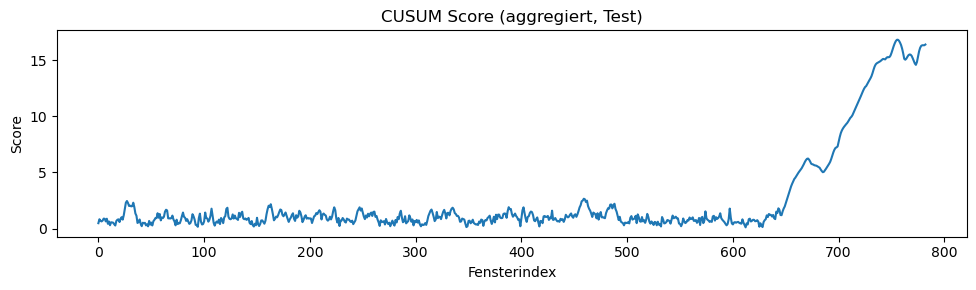

In [21]:
## WIP! Beachten der Rücksetzung nach Faultwechsel! Hier übergänge und kein >Rückschritt auf Normalniveau.
# Waehle z.B. die ersten 5 Sensoren aus dem urspruenglichen (nicht standardisierten) Feature-Satz
num_vars = noc_df.shape[1]
sel_idx = list(range(min(5, num_vars)))

# Um die Test-Fenster zeitlich zu "entrollen", nehmen wir den Durchschnittswert pro Fenster je Variable
def window_means(X_win: np.ndarray, D: int, window: int) -> np.ndarray:
    # X_win: [N, window*D] -> [N, D]
    N = X_win.shape[0]
    out = np.empty((N, D), dtype=float)
    for i in range(N):
        seg = X_win[i].reshape(window, D)
        out[i] = seg.mean(axis=0)
    return out

Xte_means = window_means(X_test, D=noc_df.shape[1], window=WINDOW)

cusum_scores = []
for d in sel_idx:
    sc = simple_cusum(Xte_means[:, d])
    cusum_scores.append(sc)
cusum_scores = np.vstack(cusum_scores).mean(axis=0)

res_cusum = eval_scores(y_test, cusum_scores, "CUSUM (aggregiert)")

plt.figure(figsize=(10,3))
plt.plot(cusum_scores)
plt.title("CUSUM Score (aggregiert, Test)")
plt.xlabel("Fensterindex")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## Bewertungsmetriken in der Übersicht

In [23]:
import numpy as np, pandas as pd

def _extract_row(name, res):
    if res is None: return None
    if isinstance(res, dict):
        roc = res.get('roc_auc', res.get('rocAUC', res.get('roc')))
        pr  = res.get('pr_auc', res.get('average_precision', res.get('ap')))
        thr = res.get('threshold', res.get('thr'))
        tpr = res.get('tpr_at_far', res.get('tpr'))
        row = {'model': name, 'roc_auc': roc, 'pr_auc': pr, 'thr': thr}
        if tpr is not None: row['tpr_at_far'] = tpr
        return row

rows = []
rows.append(_extract_row('DPCA', globals().get('res_dpca')))
rows.append(_extract_row('KPCA(RBF)', globals().get('res_kpca')))

one = globals().get('res_oneclass')
if isinstance(one, dict):
    mapping = {'isoforest':'IsolationForest','ocsvm':'OneClassSVM','lof':'LOF'}
    for k, r in one.items():
        rows.append(_extract_row(mapping.get(k, k), r))

rows.append(_extract_row('AE(MLP)', globals().get('res_ae')))
rows.append(_extract_row('CUSUM(avg)', globals().get('res_cusum')))

use_sup = globals().get('USE_SUPERVISED', True)
if use_sup:
    rf_res = globals().get('res_rf')
    if rf_res is not None:
        rows.append(_extract_row('RandomForest', rf_res))
else:
    print("ℹ Überwachtes Training deaktiviert (USE_SUPERVISED=False) – überwachte Modelle werden in der Übersicht ausgelassen.")

rows = [r for r in rows if r is not None]
if rows:
    df_metrics = pd.DataFrame(rows).sort_values('model').reset_index(drop=True)
    display(df_metrics)
else:
    print("Keine Metriken verfügbar – wurden die Methoden-Zellen ausgeführt?")


ℹ Überwachtes Training deaktiviert (USE_SUPERVISED=False) – überwachte Modelle werden in der Übersicht ausgelassen.


,model,roc_auc,pr_auc,thr
0,AE(MLP),0.927458,0.898731,None
1,CUSUM(avg),0.995012,0.986766,None
2,DPCA,0.973340,0.965468,None
3,IsolationForest,0.339063,0.127931,None
4,KPCA(RBF),0.675778,0.334053,None
5,LOF,0.893574,0.827197,None
6,OneClassSVM,0.933008,0.832349,None


# False Alarm Rate (FAR)-Schwelle, First-Alarm Index & Detektionsverzögerung

**Ziel:** Schwelle für FAR auf NOC-Test durchführen, danach First-Alarm abbilden im Bereich FAULT und Delay bis zur Erkennung in Anzahl der Fenster bestimmen.

Diese Auswertung ist für den Anwender in der Überwachung der Prozesse entscheidend. Es geht um eine zügige Fehlererkennung bei geringer Fehlalarmrate - hist ist die FAR-Rate auf den fehlerfreien Daten trainiert und eingestellt (zBsp. FAR 1%, `target_far=0.001`).
Alle zentralen Werte und Datenauswahl erfolgt im Block 0) Config zu Beginn des Notebooks.

In [25]:
# ============================================================
# threshold_and_alarm_report – erweitert um Fault-Segmente
#  • FAR-Schwelle auf NOC-Testteil (len(X_noc_test))
#  • globaler First-Alarm (ab NOC→FAULT-Grenze)
#  • First-Alarm im Segment + Delay_im_Segment
#  • Plots: Score, Schwelle, NOC→FAULT-Grenze, Fault-Startlinien inkl. Labels
# 
# Optional: FILES oder data + fault_keys (für exakte Segment-Längen). Falls nicht vorhanden, werden Segmente
#           heuristisch gleichmäßig aus y_test>0 abgeleitet (Fallback-Lösung!).
# Rückgabe: df_overall, df_segments
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---- Hilfsfunktionen ----

### achtung hier auch far probleme?

def far_threshold(noc_scores: np.ndarray, target_far: float = 0.01) -> float:
    noc_scores = np.asarray(noc_scores, dtype=float)
    noc_scores = noc_scores[np.isfinite(noc_scores)]
    if noc_scores.size == 0:
        return np.nan
    q = np.clip(1.0 - float(target_far), 0.0, 1.0)
    return float(np.quantile(noc_scores, q))

def first_alarm_index(scores: np.ndarray, thr: float, start_idx: int) -> int:
    s = np.asarray(scores, dtype=float)
    if not np.isfinite(thr) or start_idx >= len(s):
        return -1
    hits = np.where(s[start_idx:] >= thr)[0]
    return (start_idx + int(hits[0])) if hits.size > 0 else -1

def collect_available_scores(y_test: np.ndarray) -> dict:
    N = len(y_test)
    out = {}
    g = globals()
    if "dpca_te" in g and hasattr(g["dpca_te"], "__len__") and len(g["dpca_te"]) == N:
        out["DPCA"] = np.asarray(g["dpca_te"], float)
    if "kpca_te" in g and hasattr(g["kpca_te"], "__len__") and len(g["kpca_te"]) == N:
        out["KPCA(RBF)"] = np.asarray(g["kpca_te"], float)
    if "scores" in g and isinstance(g["scores"], dict):
        for key, arr in g["scores"].items():
            if hasattr(arr, "__len__") and len(arr) == N:
                out[{"isoforest":"IsolationForest","ocsvm":"OneClassSVM","lof":"LOF"}.get(key, key)] = np.asarray(arr, float)
    if "ae_te" in g and hasattr(g["ae_te"], "__len__") and len(g["ae_te"]) == N:
        out["AE(MLP)"] = np.asarray(g["ae_te"], float)
    if "cusum_scores" in g and hasattr(g["cusum_scores"], "__len__") and len(g["cusum_scores"]) == N:
        out["CUSUM(avg)"] = np.asarray(g["cusum_scores"], float)
    return out

# ---- Fault-Segment-Rekonstruktion ----
def _window_count(T, window, hop):
    if T < window: return 0
    return 1 + (T - window) // hop

def _fault_segments_from_files(n_noc, window, hop, fault_keys=None, fault_labels=None):
    """
    Rekonstruiert Segmentgrenzen aus den CSV/DF-Längen pro Fault.
    Nutzt FILES[fk] oder data[fk]. Gibt Liste [(label, s_abs, e_abs), ...] zurück.
    """
    if fault_keys is None:
        if "fault_keys" in globals():
            fk_list = list(globals()["fault_keys"])
        elif "FILES" in globals():
            fk_list = [k for k in FILES if "FAULT" in k.upper()]
        elif "data" in globals():
            fk_list = [k for k in data if "FAULT" in k.upper()]
        else:
            raise RuntimeError("fault_keys nicht gefunden – bitte fault_keys setzen oder FILES/data bereitstellen.")
    else:
        fk_list = list(fault_keys)

    counts = []
    for fk in fk_list:
        if "FILES" in globals() and isinstance(FILES, dict) and fk in FILES and os.path.exists(FILES[fk]):
            import pandas as pd
            df = pd.read_csv(FILES[fk])
            T = len(df)
        elif "data" in globals() and isinstance(data, dict) and fk in data:
            T = len(data[fk])
        else:
            raise RuntimeError(f"Kein CSV/DF für Fault-Key '{fk}' gefunden (FILES/data).")
        counts.append(_window_count(T, window, hop))

    segs = []
    s = int(n_noc)
    for i, (fk, cnt) in enumerate(zip(fk_list, counts)):
        e = s + int(cnt)
        label = (fault_labels[i] if (fault_labels and i < len(fault_labels)) else fk)
        segs.append((label, s, e))
        s = e
    return segs

def _fault_segments_from_ytest(n_noc, y): 
    """
    Fallback, wenn keine FILES/data vorhanden sind:
    teilt den Fault-Bereich heuristisch in gleich große Stücke pro einzigartigem Fault-Key,
    oder gibt einen Block zurück (wenn keine Info vorhanden).
    """
    N = len(y)
    if "fault_keys" in globals() and len(globals()["fault_keys"]) > 0:
        k = len(globals()["fault_keys"])
        rest = N - n_noc
        if rest <= 0: return []
        approx = rest // k
        segs = []
        s = n_noc
        for i in range(k):
            e = s + approx if i < k-1 else N
            segs.append((str(globals()["fault_keys"][i]), s, e))
            s = e
        return segs
    else:
        # Ein Block als Fallback
        return [("FAULTS", n_noc, N)]

# ---- Reportanalyse ----
### achtung hier falscher far auf basis float und nicht übernommen!

def threshold_and_alarm_report(target_far: float = 0.01, plot_each: bool = True,
                               save_csv: str = "threshold_alarm_summary.csv",
                               with_segments: bool = True,
                               save_segments_csv: str = "threshold_alarm_per_segment.csv",
                               fault_keys=None, fault_labels=None):
    # Preflights
    for need in ["X_noc_test","y_test"]:
        if need not in globals():
            raise NameError(f"'{need}' fehlt – bitte Test-Split-/Fenster-Zellen ausführen.")
    if with_segments and ("WINDOW" not in globals() or "HOP" not in globals()):
        raise NameError("WINDOW/HOP fehlen für Segmentgrenzen (bitte oben definieren).")

    y = np.asarray(y_test).astype(int)
    n_noc = int(len(X_noc_test))
    assert len(y) >= n_noc, "y_test kürzer als NOC-Testteil?"

    # Scores einsammeln
    scores_dict = collect_available_scores(y)
    if not scores_dict:
        raise RuntimeError("Keine Scores gefunden – bitte Methoden-Zellen ausführen (DPCA/KPCA/One-Class/AE/CUSUM).")

    # Fault-Segmente bestimmen
    segments = []
    if with_segments:
        try:
            segments = _fault_segments_from_files(n_noc, int(WINDOW), int(HOP),
                                                  fault_keys=fault_keys, fault_labels=fault_labels)
        except Exception as ex:
            # Fallback auf y_test-Heuristik
            print(f"ℹ Segment-Rekonstruktion aus Dateien nicht möglich ({ex}) – verwende Heuristik aus y_test.")
            segments = _fault_segments_from_ytest(n_noc, y)

    # ---- Gesamt-Auswertung pro Modell
    overall_rows = []
    seg_rows = []

    for name, sc in scores_dict.items():
        thr = far_threshold(sc[:n_noc], target_far=target_far)
        idx_global = first_alarm_index(sc, thr, start_idx=n_noc)
        delay_global = (idx_global - n_noc) if idx_global >= 0 else np.nan

        overall_rows.append({
            "model": name,
            "thr": thr,
            "first_alarm_idx": (idx_global if idx_global >= 0 else np.nan),
            "delay_seq": delay_global
        })

        # ---- pro Segment (falls gewünscht)
        if with_segments and segments:
            for (label, s_abs, e_abs) in segments:
                s_abs, e_abs = int(s_abs), int(e_abs)
                seg_idx = np.nan
                seg_delay = np.nan
                if np.isfinite(thr) and s_abs < e_abs <= len(sc):
                    hit = np.where(sc[s_abs:e_abs] >= thr)[0]
                    if hit.size > 0:
                        seg_idx = s_abs + int(hit[0])
                        seg_delay = int(hit[0])  # Delay der Detektion relativ zum Segmentstart
                seg_rows.append({
                    "model": name,
                    "fault_segment": str(label),
                    "seg_start_idx": s_abs,
                    "seg_end_idx": e_abs,
                    "first_alarm_idx_seg": (int(seg_idx) if np.isfinite(seg_idx) else np.nan),
                    "delay_seq_seg": (int(seg_delay) if np.isfinite(seg_delay) else np.nan),
                    "thr": thr
                })

        # ---- Plot pro Modell
        if plot_each:
            fig = plt.figure(figsize=(12,4)); ax = plt.gca()
            xs = np.arange(len(sc))
            ax.plot(xs, sc, label=f"{name} – Score")
            # NOC→FAULT-Grenze
            ax.axvline(n_noc, color="gray", linestyle="--", alpha=0.8)
            ax.text(n_noc, ax.get_ylim()[1]*0.96, "Start Faults", ha="left", va="top", color="gray")

            # Fault-Segmentstarts + Labels
            if with_segments and segments:
                y0, y1 = ax.get_ylim()
                for (label, s_abs, e_abs) in segments:
                    ax.axvline(int(s_abs), color="gray", linestyle=":", alpha=0.6)
                    ax.text(int(s_abs), y0 + 0.05*(y1-y0), str(label), rotation=90, va="bottom", ha="left", fontsize=9, color="gray")

            # Schwelle
            if np.isfinite(thr):
                ax.axhline(thr, color="C1", linestyle="--", alpha=0.85, label=f"thr @ FAR={target_far*100:.1f}%")

            # globaler erster Alarm
            if idx_global >= 0:
                ax.axvline(idx_global, color="C3", linestyle="-", alpha=0.9)
                ax.text(idx_global, ax.get_ylim()[0] + 0.9*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        f"Alarm @ idx {idx_global}", rotation=90, ha="left", va="top", color="C3")

            ax.set_title(f"{name}: Score – Schwelle, Fault-Grenzen & Alarm")
            ax.set_xlabel("Fensterindex")
            ax.set_ylabel("Score / Rekonstruktionsfehler")
            ax.legend()
            plt.tight_layout(); plt.show()

    # ---- Tabellen ausgeben/speichern
    df_overall = pd.DataFrame(overall_rows).sort_values("model").reset_index(drop=True)
    display(df_overall)
    if save_csv:
        df_overall.to_csv(save_csv, index=False)
        print(f"✔ gespeichert: {save_csv}")

    df_segments = None
    if with_segments and seg_rows:
        df_segments = pd.DataFrame(seg_rows)
        # Optionale Sortierung
        if "fault_segment" in df_segments.columns:
            # Reihenfolge der Segmente wie gebaut
            seg_order = [str(s[0]) for s in segments]
            df_segments["fault_segment"] = pd.Categorical(df_segments["fault_segment"], categories=seg_order, ordered=True)
            df_segments = df_segments.sort_values(["model","fault_segment"]).reset_index(drop=True)
        display(df_segments)
        if save_segments_csv:
            df_segments.to_csv(save_segments_csv, index=False)
            print(f"✔ gespeichert: {save_segments_csv}")

    # ---- Vergleichsbalken
    order = list(df_overall["model"].values)
    x = np.arange(len(order))

    fig = plt.figure(figsize=(10,4)); ax = plt.gca()
    vals = df_overall.set_index("model").loc[order]["delay_seq"].values.astype(float)
    bars = ax.bar(x, np.nan_to_num(vals, nan=0.0))
    for i,v in enumerate(vals):
        if np.isnan(v):
            bars[i].set_alpha(0.3); bars[i].set_hatch("//"); ax.text(i, 0.01, "NaN", ha="center", va="bottom", fontsize=9)
        else:
            ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
    ax.set_xticks(x); ax.set_xticklabels(order)
    ax.set_ylabel("Detektionsverzögerung (Fenster)")
    ax.set_title("Detektionsverzögerung pro Modell (gesamt, FAR-basiert)")
    plt.tight_layout(); plt.show()

    fig = plt.figure(figsize=(10,4)); ax = plt.gca()
    vals2 = df_overall.set_index("model").loc[order]["first_alarm_idx"].values.astype(float)
    bars2 = ax.bar(x, np.nan_to_num(vals2, nan=0.0))
    for i,v in enumerate(vals2):
        if np.isnan(v):
            bars2[i].set_alpha(0.3); bars2[i].set_hatch("//"); ax.text(i, 0.01, "NaN", ha="center", va="bottom", fontsize=9)
        else:
            ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
    ax.set_xticks(x); ax.set_xticklabels(order)
    ax.set_ylabel("Frühester Alarmindex (gesamt)")
    ax.set_title("Frühester Alarmindex pro Modell (gesamt)")
    plt.tight_layout(); plt.show()

    return df_overall, df_segments

# ▶ Beispiel:
#df_overall, df_segments = threshold_and_alarm_report(
#    target_far=0.01, plot_each=True,
#    save_csv="threshold_alarm_summary.csv",
#    with_segments=True, save_segments_csv="threshold_alarm_per_segment.csv"
#)


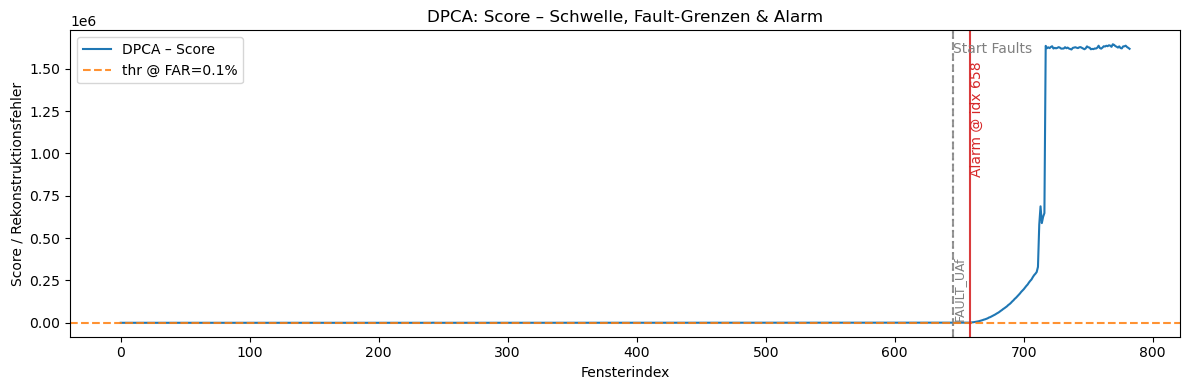

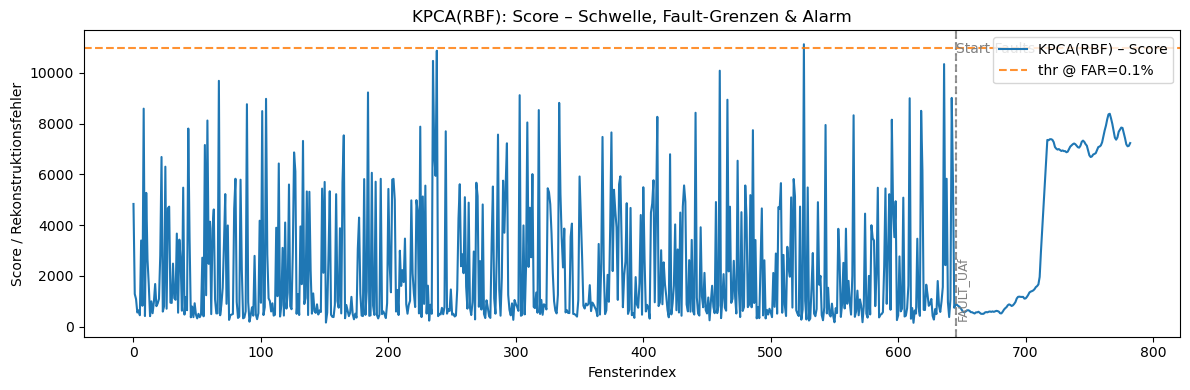

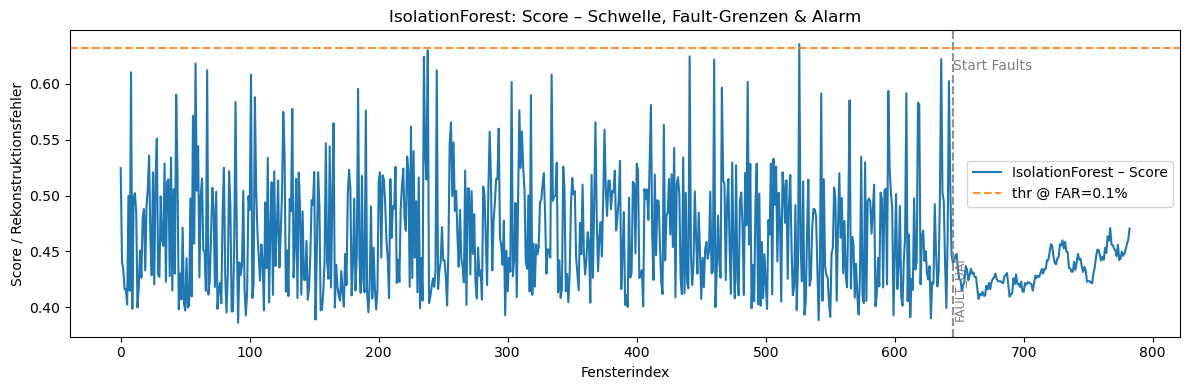

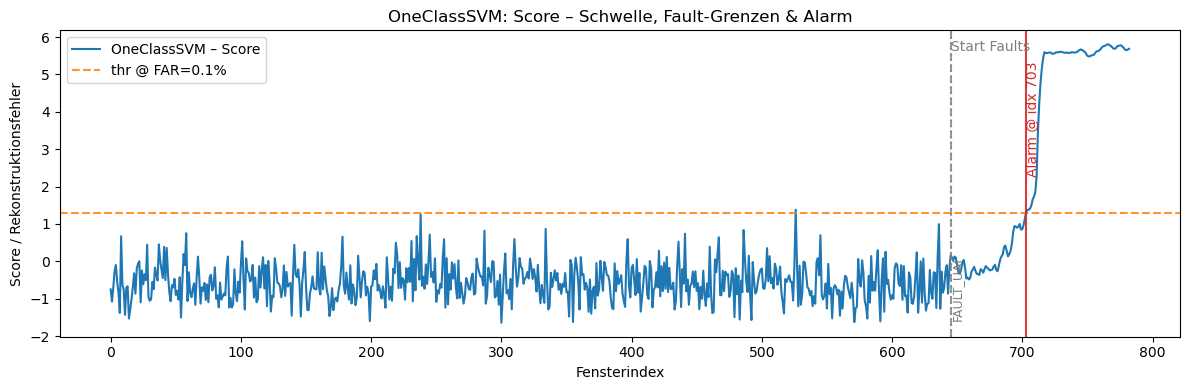

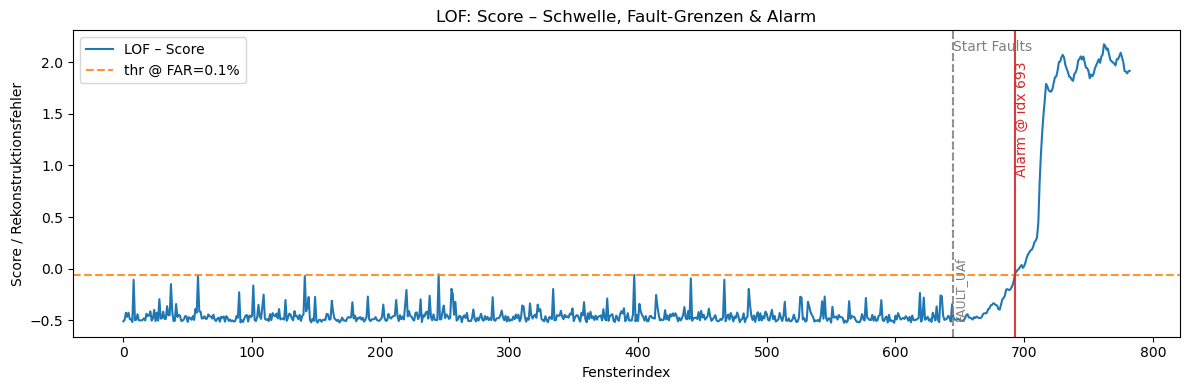

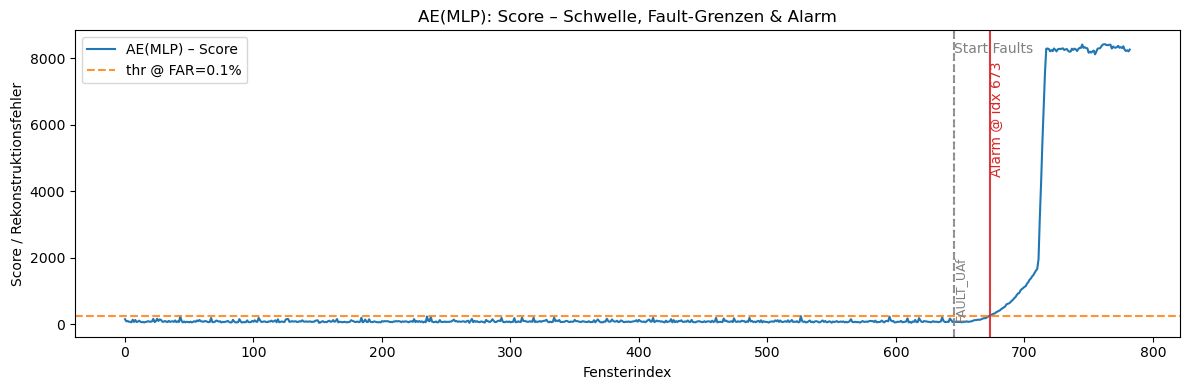

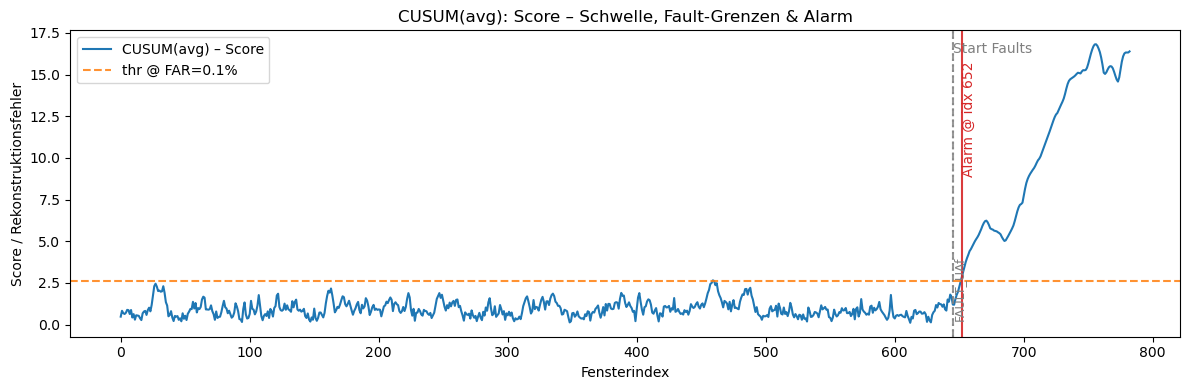

,model,thr,first_alarm_idx,delay_seq
0,AE(MLP),233.308779,673.0,28.0
1,CUSUM(avg),2.622465,652.0,7.0
2,DPCA,595.605032,658.0,13.0
3,IsolationForest,0.632074,NaN,NaN
4,KPCA(RBF),10961.616286,NaN,NaN
5,LOF,-0.059332,693.0,48.0
6,OneClassSVM,1.302451,703.0,58.0


✔ gespeichert: threshold_alarm_summary.csv


,model,fault_segment,seg_start_idx,seg_end_idx,first_alarm_idx_seg,delay_seq_seg,thr
0,AE(MLP),FAULT_UAf,645,783,673.0,28.0,233.308779
1,CUSUM(avg),FAULT_UAf,645,783,652.0,7.0,2.622465
2,DPCA,FAULT_UAf,645,783,658.0,13.0,595.605032
3,IsolationForest,FAULT_UAf,645,783,NaN,NaN,0.632074
4,KPCA(RBF),FAULT_UAf,645,783,NaN,NaN,10961.616286
5,LOF,FAULT_UAf,645,783,693.0,48.0,-0.059332
6,OneClassSVM,FAULT_UAf,645,783,703.0,58.0,1.302451


✔ gespeichert: threshold_alarm_per_segment.csv


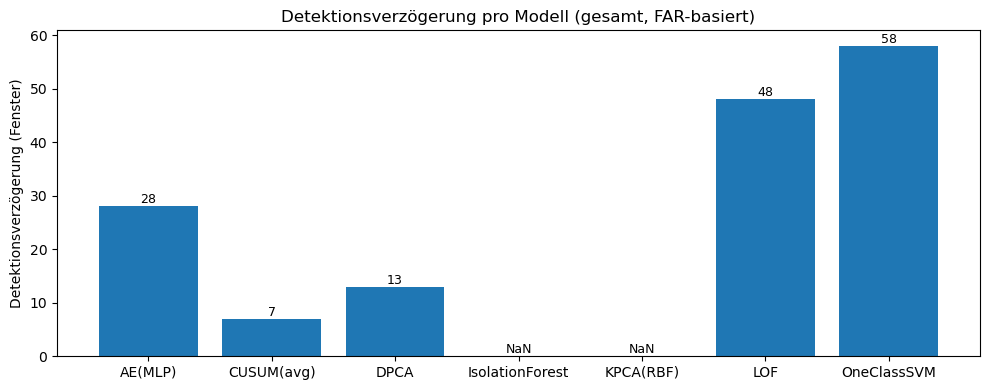

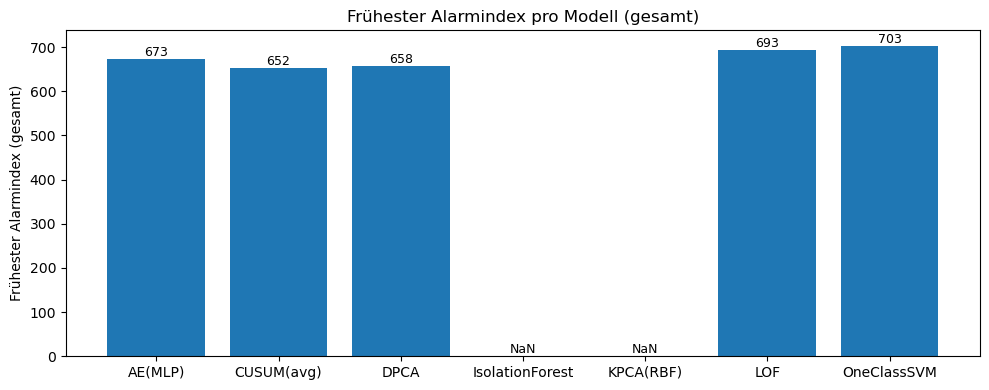

In [26]:
df_thr_alarm = threshold_and_alarm_report(target_far, plot_each=True)